In [13]:
# imports
import os
import shutil
import json
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

from eagle.ovORFs.overlap_description import detect_frame_antiparallel, get_overlap_length

%matplotlib notebook

In [53]:
# constants
WORK_DIR = "../data/ORFs_classifier"

ESS_COLOR = "purple"
ADV_COLOR = "orange"
OTHER_COLOR = "skyblue"

FRAME_REV2_HANDLE = 1  # 0 - do nothing; 1 - ignore while transform; 2 - ignore while fit and transform

In [3]:
# lib
def get_gtf_df(eagle_orfs_gtf_path, annot_gtf_path=None):
    gtf_df = pd.read_csv(eagle_orfs_gtf_path, sep="\t")
    gtf_df = pd.concat((gtf_df, pd.DataFrame(list(gtf_df.apply(parse_attr_col, axis=1)))), axis=1)
    gtf_df["representation"] = 1.0 - gtf_df["representation"]
    gtf_df["uniformity_std"] = gtf_df["uniformity_std"].apply(lambda x, max_x: 1.0 - x/max_x if x > 0.0 else x, args=(gtf_df["uniformity_std"].max(),))  # new 
    if annot_gtf_path is not None:
        annot_gtf_df = pd.read_csv(annot_gtf_path, sep="\t", header=None)
        if tuple(annot_gtf_df.iloc[0]) == ("seqid", "source", "type", "start", "end", "score", "strand", "frame", "attribute"):
            annot_gtf_df = annot_gtf_df.drop(0).reset_index(drop=True)
        annot_gtf_df.columns = ("seqid", "source", "type", "start", "end", "score", "strand", "frame", "attribute")
        # ori_gr = gtf_df.groupby(by="strand")
        # annot_ori_gr = annot_gtf_df.groupby(by="strand")
        gtf_df = gtf_df.astype({"seqid": str, "start": int, "end": int})
        gtf_df["annot_score"] = gtf_df.apply(detect_gtf_intersect, axis=1, args=(annot_gtf_df.astype({"seqid": str, "start": int, "end": int}),))
        # fwd_gtf_df = ori_gr.get_group("+").astype({"seqid": str, "start": int, "end": int})
        # rev_gtf_df = ori_gr.get_group("-").astype({"seqid": str, "start": int, "end": int})
        # fwd_gtf_df["annot_score"] = fwd_gtf_df.apply(detect_gtf_intersect, axis=1, args=(annot_ori_gr.get_group("+").astype({"seqid": str, "start": int, "end": int}),))
        # rev_gtf_df["annot_score"] = rev_gtf_df.apply(detect_gtf_intersect, axis=1, args=(annot_ori_gr.get_group("-").astype({"seqid": str, "start": int, "end": int}),))
        # gtf_df = merge_gtf_dfs(fwd_gtf_df, rev_gtf_df)
    return gtf_df


def merge_gtf_dfs(gtf_df1, gtf_df2):
    gtf_df = pd.concat((gtf_df1, gtf_df2))
    return gtf_df.sort_values(["seqid", "start"]).reset_index(drop=True)


def detect_gtf_intersect(row, inter_gtf_df):
    max_inter = 0.0
    query = 'seqid == "%s" & end >= %s & start <= %s & strand == "%s"' % (row["seqid"], row["start"], row["end"], row["strand"])
    for i, row_ in inter_gtf_df.query(query).iterrows():
        cur_inter = float(min(row["end"], row_["end"]) - max(row["start"], row_["start"]) + 1) / float(max(row["end"], row_["end"]) - min(row["start"], row_["start"]) + 1)
        if cur_inter > max_inter:
            max_inter = cur_inter
    return max_inter


def parse_attr_col(row):
    attr_dict = json.loads(row["attribute"])
    return {
        "uniformity_std": attr_dict["uniformity_std"],
        "phylo_diff": attr_dict["phylo_diff"],
        "ORF_l": row["end"] - row["start"] + 1,
        "representation": attr_dict["representation"],
        "relative_median_btax_dist": attr_dict["relative_median_btax_dist"],
        "relative_mean_btax_dist": attr_dict["relative_mean_btax_dist"],
        "relative_median_ORF_dist": attr_dict["relative_median_ORF_dist"],
        "relative_mean_ORF_dist": attr_dict["relative_mean_ORF_dist"],
        "Ka/Ks": attr_dict["Ka/Ks"],
        "n_seqs_with_stops": attr_dict["n_seqs_with_stops"],###
        #"seqs_with_stops_fract": attr_dict["seqs_with_stops_fract"],
        "stops_per_seq_median": attr_dict["stops_per_seq_median"],
    }


def get_annot_group(row, annot_threshold=0.75):
    if row["annot_ess"] >= annot_threshold:
        return "essential"
    if row["annot_noness"] >= annot_threshold:
        return "advantageous"
    else:
        return "other"
    
    
def detect_rev2_ORF(row, gtf_df):
    if row["annot_group"] == "other":
        if row["strand"] == "+":
            query = 'seqid == "%s" & end >= %s & start <= %s & strand == "-"' % (row["seqid"], row["start"], row["end"])
        else:
            query = 'seqid == "%s" & end >= %s & start <= %s & strand == "+"' % (row["seqid"], row["start"], row["end"])
        for i, row_ in gtf_df.query(query).iterrows():
            if row_["annot_group"] != "other":
                if get_overlap_length(orf_c=(row_["start"], row_["end"]), ovorf_c=(row["start"], row["end"])) >= 180:
                    if detect_frame_antiparallel(orf_c=(row_["start"], row_["end"]), ovorf_c=(row["start"], row["end"]), orf_ori=row_["strand"]) == -2:
                        return True
    return False

In [4]:
eagle_orfs_gtf_path = os.path.join(WORK_DIR, "NC_000913.fasta.gtf")
deg_essential_gtf_path = os.path.join(WORK_DIR, "DEG1018_essential.gtf")
deg_nonessential_gtf_path = os.path.join(WORK_DIR, "DEG1018_nonessential_ncbi.gtf")
gms2_gtf_path = os.path.join(WORK_DIR, "NC_000913_gms2.gtf")

gtf_df_ess = get_gtf_df(eagle_orfs_gtf_path, deg_essential_gtf_path)
gtf_df_noness = get_gtf_df(eagle_orfs_gtf_path, deg_nonessential_gtf_path)
gtf_df = gtf_df_ess[list(gtf_df_ess.columns)[:-1]]
gtf_df["annot_ess"], gtf_df["annot_noness"] = gtf_df_ess["annot_score"], gtf_df_noness["annot_score"]
gtf_df["annot_group"] = gtf_df.apply(get_annot_group, axis=1)
gtf_df["frame_rev2"] = gtf_df.apply(detect_rev2_ORF, axis=1, args=(gtf_df,))
gtf_df["gms2_annot"] = gtf_df.apply(detect_gtf_intersect, axis=1, args=(pd.read_csv(gms2_gtf_path, sep="\t"),))
# nona_gtf_df = gtf_df.dropna()

In [5]:
# if NAs occured wrongly
gtf_df.fillna(-1.0, inplace=True)
gtf_df["Ka/Ks"][gtf_df["Ka/Ks"] > 10.0] = -1.0

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
gtf_df.head(10)

seqid source type  start   end score strand frame  \
0  NC_000913.3  EAGLE  ORF    111   620     -      -     .   
1  NC_000913.3  EAGLE  ORF    292  2796     -      +     .   
2  NC_000913.3  EAGLE  ORF   2792  3730     -      +     .   
3  NC_000913.3  EAGLE  ORF   3515  4174     -      -     .   
4  NC_000913.3  EAGLE  ORF   3734  5017     -      +     .   
5  NC_000913.3  EAGLE  ORF   3814  4158     -      -     .   
6  NC_000913.3  EAGLE  ORF   4417  4728     -      +     .   
7  NC_000913.3  EAGLE  ORF   4542  4877     -      -     .   
8  NC_000913.3  EAGLE  ORF   5313  5768     -      -     .   
9  NC_000913.3  EAGLE  ORF   5491  5943     -      +     .   

                                           attribute     Ka/Ks     ...      \
0  {"phylo_diff": 0.775, "relative_mean_ORF_dist"...  0.228115     ...       
1  {"phylo_diff": 0.7380952380952381, "relative_m...  0.051872     ...       
2  {"phylo_diff": 0.7073170731707317, "relative_m...  0.044974     ...       
3  {"phylo_diff": 0.7837837837837838, "relative_m...  1.374193     ...       
4  {"phylo_diff": 0.6829268292682927, "relative_m...  0.033800     ...       
5  {"phylo_diff": 0.7317073170731707, "relative_m...  0.153593     ...       
6  {"phylo_diff": 0.8108108108108109, "relative_m...  8.978542     ...       
7  {"phylo_diff": 0.7142857142857143, "relative_m... -1.000000     ...       
8  {"phylo_diff": 0.9375, "relative_mean_ORF_dist...  0.336463     ...       
9  {"phylo_diff": 0.8918918918918919, "relative_m...  1.180371     ...       

   relative_median_ORF_dist  relative_median_btax_dist  representation  \
0                  3.814226                   9.490840        0.085106   
1                  1.200199                   3.733176        0.042553   
2                  1.489988                   3.976811        0.063830   
3                 12.257126                  12.791006        0.148936   
4                  1.416871                   2.993802        0.063830   
5                  2.661784                   5.624434        0.063830   
6                 12.773853                  13.218417        0.148936   
7                  1.541620                  16.256923        0.191489   
8                  0.522600                   4.648394        0.595745   
9                 21.349334                  31.046114        0.148936   

   stops_per_seq_median  uniformity_std  annot_ess  annot_noness  \
0                   1.0        0.000000        0.0      0.000000   
1                   0.0        0.831634        0.0      0.980861   
2                   0.0        0.596392        0.0      0.987261   
3                   1.0        0.745305        0.0      0.000000   
4                   0.0        0.434304        0.0      0.997669   
5                   0.0        0.579988        0.0      0.000000   
6                   2.0        0.785127        0.0      0.242424   
7                   1.0        0.827972        0.0      0.000000   
8                   0.0        0.948770        0.0      0.074978   
9                   0.0        0.937440        0.0      0.056338   

    annot_group  frame_rev2  gms2_annot  
0         other       False    0.105615  
1  advantageous       False    0.980861  
2  advantageous       False    0.987261  
3         other       False    0.292829  
4  advantageous       False    0.997669  
5         other       False    0.268065  
6         other       False    0.242424  
7         other       False    0.261072  
8         other       False    0.407477  
9         other       False    0.269350  

[10 rows x 25 columns]

In [9]:
# scaling features
features = [
    "Ka/Ks", 
    "ORF_l", 
    "n_seqs_with_stops",###
    # "seqs_with_stops_fract",  
    "phylo_diff", 
    "relative_mean_ORF_dist", 
    "relative_mean_btax_dist", 
    "relative_median_ORF_dist", 
    "relative_median_btax_dist", 
    "representation", 
    "stops_per_seq_median", 
    "uniformity_std"]
sf_gtf_df = gtf_df[features].apply(lambda col: col.apply(lambda v, max_v: float(v)/float(max_v)  if v > 0.0 else v, args=(col.quantile(0.9),)))

<IPython.core.display.Javascript object>


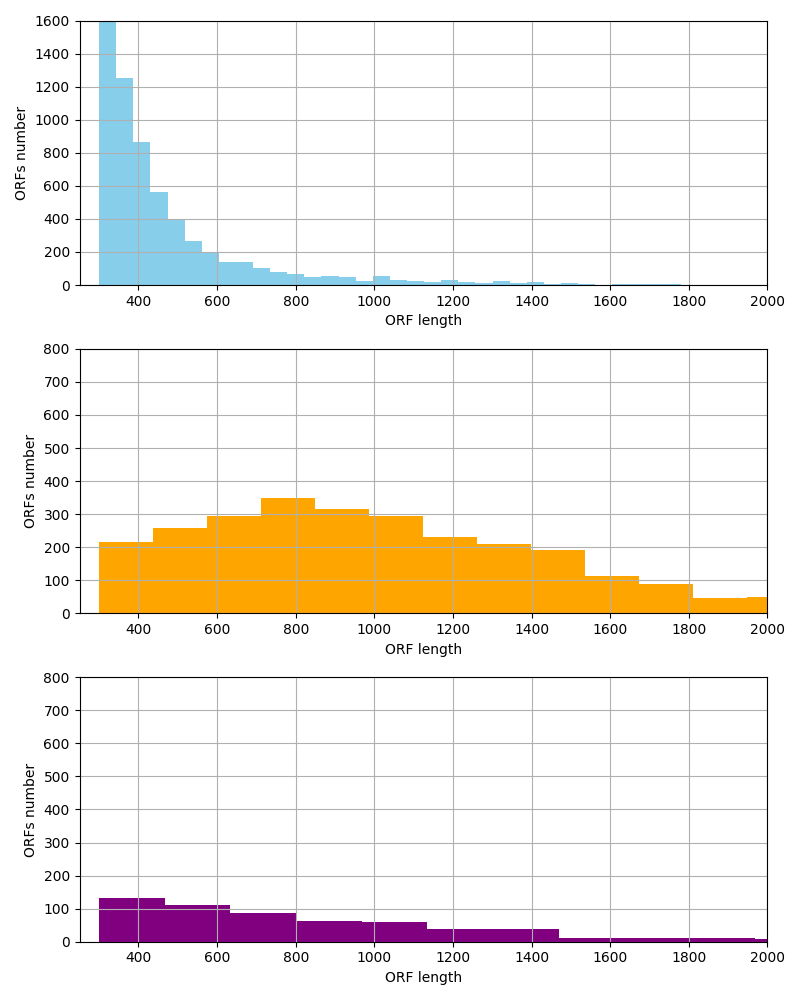

In [88]:
fig = plt.figure(figsize=(8, 10))

x1, x2 = 250, 2000
y1, y2 = 0, 800
y_other = 1600
x_label = "ORF length"
y_label = "ORFs number"

ax1 = fig.add_subplot(311)
ax1 = gtf_df[gtf_df["annot_group"] == "other"]["ORF_l"].hist(bins=100, color=OTHER_COLOR)
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y_other)

ax2 = fig.add_subplot(312)
ax2 = gtf_df[gtf_df["annot_group"] == "advantageous"]["ORF_l"].hist(bins=50, color=ADV_COLOR)
ax2.set_xlabel(x_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x1, x2)
ax2.set_ylim(y1, y2)

ax3 = fig.add_subplot(313)
ax3 = gtf_df[gtf_df["annot_group"] == "essential"]["ORF_l"].hist(bins=25, color=ESS_COLOR)
ax3.set_xlabel(x_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x1, x2)
ax3.set_ylim(y1, y2)

fig.tight_layout()

## Decomposition

In [72]:
# PCA
pca = PCA(n_components=3)

if FRAME_REV2_HANDLE <= 1:
    pca.fit(sf_gtf_df)
else:
    pca.fit(sf_gtf_df[~gtf_df["frame_rev2"]])
if FRAME_REV2_HANDLE == 0:
    pca_gtf_df = pd.concat((gtf_df[["seqid", "start", "end", "strand", "annot_group", "frame_rev2", "gms2_annot"]], pd.DataFrame(pca.transform(sf_gtf_df), columns=["pca1", "pca2", "pca3"])), axis=1)
else:
    pca_gtf_df = pd.concat((gtf_df[["seqid", "start", "end", "strand", "annot_group", "frame_rev2", "gms2_annot"]], pd.DataFrame(pca.transform(sf_gtf_df), columns=["pca1", "pca2", "pca3"])), axis=1)[~gtf_df["frame_rev2"]].reset_index(drop=True)    

# PCA stats
components = [{feature: component[i] for i, feature in enumerate(features)} for component in pca.components_]
print(json.dumps(components, indent=2))
features_contrib = defaultdict(float)
for component in components:
    for feature in features:
        features_contrib[feature] += abs(component[feature])
print(json.dumps(OrderedDict(sorted(features_contrib.items(), key=lambda f: f[1], reverse=True)), indent=2))
print(pca.explained_variance_ratio_)

[
  {
    "phylo_diff": 0.08627357061095342, 
    "relative_mean_ORF_dist": 0.3037071748187953, 
    "Ka/Ks": 0.359872635429352, 
    "stops_per_seq_median": 0.48987164440680253, 
    "relative_median_ORF_dist": 0.30067089639341915, 
    "representation": -0.1505651970194553, 
    "ORF_l": -0.03405741510265714, 
    "relative_mean_btax_dist": 0.37045776594319946, 
    "n_seqs_with_stops": 0.3481519787833195, 
    "relative_median_btax_dist": 0.3599087540900604, 
    "uniformity_std": 0.16917576448445545
  }, 
  {
    "phylo_diff": 0.05174550951461952, 
    "relative_mean_ORF_dist": 0.3904259972552979, 
    "Ka/Ks": -0.36314516189566726, 
    "stops_per_seq_median": -0.47549226472200123, 
    "relative_median_ORF_dist": 0.38414636185633566, 
    "representation": -0.1047668198925818, 
    "ORF_l": 0.2682622324921174, 
    "relative_mean_btax_dist": 0.3308000195696335, 
    "n_seqs_with_stops": -0.27697797089119436, 
    "relative_median_btax_dist": 0.2645313597087938, 
    "uniformity_s

<IPython.core.display.Javascript object>


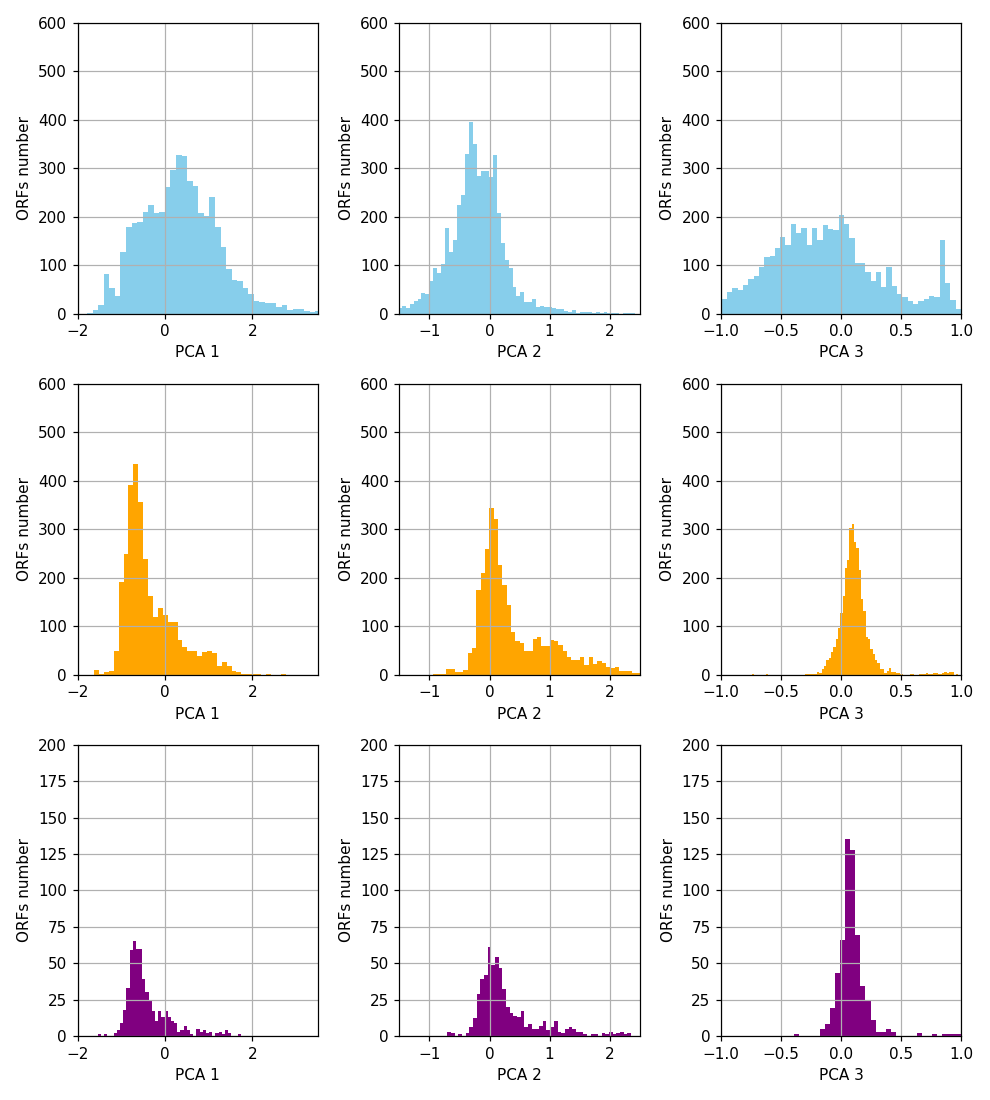

In [55]:
fig = plt.figure(figsize=(9, 10))

x11, x12 = -2.0, 3.5
y1, y2 = 0, 600
y_ess = 200
x21, x22 = -1.5, 2.5
x31, x32 = -1.0, 1.0
x1_label = "PCA 1"
x2_label = "PCA 2"
x3_label = "PCA 3"
y_label = "ORFs number"

ax1 = fig.add_subplot(331)
ax1 = pca_gtf_df[pca_gtf_df["annot_group"] == "other"]["pca1"].hist(bins=80, color=OTHER_COLOR)
ax1.set_xlabel(x1_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x11, x12)
ax1.set_ylim(y1, y2)

ax4 = fig.add_subplot(334)
ax4 = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"]["pca1"].hist(bins=80, color=ADV_COLOR)
ax4.set_xlabel(x1_label)
ax4.set_ylabel(y_label)
ax4.set_xlim(x11, x12)
ax4.set_ylim(y1, y2)

ax7 = fig.add_subplot(337)
ax7 = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"]["pca1"].hist(bins=80, color=ESS_COLOR)
ax7.set_xlabel(x1_label)
ax7.set_ylabel(y_label)
ax7.set_xlim(x11, x12)
ax7.set_ylim(y1, y_ess)

ax2 = fig.add_subplot(332)
ax2 = pca_gtf_df[pca_gtf_df["annot_group"] == "other"]["pca2"].hist(bins=180, color=OTHER_COLOR)
ax2.set_xlabel(x2_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x21, x22)
ax2.set_ylim(y1, y2)

ax5 = fig.add_subplot(335)
ax5 = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"]["pca2"].hist(bins=100, color=ADV_COLOR)
ax5.set_xlabel(x2_label)
ax5.set_ylabel(y_label)
ax5.set_xlim(x21, x22)
ax5.set_ylim(y1, y2)

ax8 = fig.add_subplot(338)
ax8 = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"]["pca2"].hist(bins=50, color=ESS_COLOR)
ax8.set_xlabel(x2_label)
ax8.set_ylabel(y_label)
ax8.set_xlim(x21, x22)
ax8.set_ylim(y1, y_ess)

ax3 = fig.add_subplot(333)
ax3 = pca_gtf_df[pca_gtf_df["annot_group"] == "other"]["pca3"].hist(bins=180, color=OTHER_COLOR)
ax3.set_xlabel(x3_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x31, x32)
ax3.set_ylim(y1, y2)

ax6 = fig.add_subplot(336)
ax6 = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"]["pca3"].hist(bins=150, color=ADV_COLOR)
ax6.set_xlabel(x3_label)
ax6.set_ylabel(y_label)
ax6.set_xlim(x31, x32)
ax6.set_ylim(y1, y2)

ax9 = fig.add_subplot(339)
ax9 = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"]["pca3"].hist(bins=50, color=ESS_COLOR)
ax9.set_xlabel(x3_label)
ax9.set_ylabel(y_label)
ax9.set_xlim(x31, x32)
ax9.set_ylim(y1, y_ess)

fig.tight_layout()

<IPython.core.display.Javascript object>


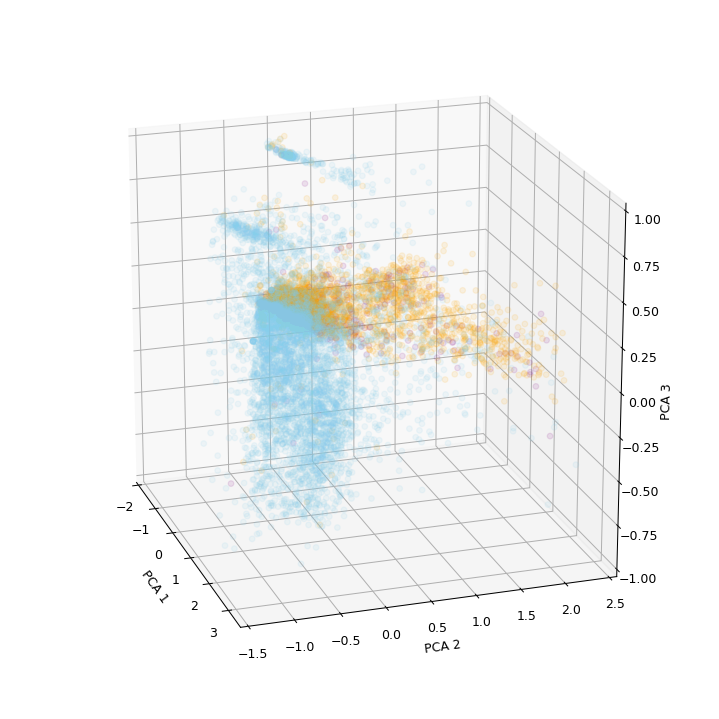

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:

In [12]:
alpha = 0.1
pca1_1, pca1_2 = -2.0, 3.5
pca2_1, pca2_2 = -1.5, 2.5
pca3_1, pca3_2 = -1.0, 1.0
pca_query = ("pca1 >= {pca1_1} & pca1 <= {pca1_2} & " 
             "pca2 >= {pca2_1} & pca2 <= {pca2_2} & " 
             "pca3 >= {pca3_1} & pca3 <= {pca3_2}").format(pca1_1=pca1_1, pca1_2=pca1_2,
                                                           pca2_1=pca2_1, pca2_2=pca2_2,
                                                           pca3_1=pca3_1, pca3_2=pca3_2)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca1"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca2"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca3"],
           c=OTHER_COLOR,
           alpha=alpha)

ax.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca1"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca2"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca3"],
           c=ADV_COLOR,
           alpha=alpha)

ax.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca1"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca2"],
           pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca3"],
           c=ESS_COLOR,
           alpha=alpha)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_xlim(pca1_1, pca1_2)
ax.set_ylim(pca2_1, pca2_2)
ax.set_zlim(pca3_1, pca3_2)

fig.tight_layout()

In [61]:
# preparation fo EAGLE features analysis
if FRAME_REV2_HANDLE == 0:
    rev2h_gtf_df = gtf_df
    rev2h_sf_gtf_df = sf_gtf_df
else:
    rev2h_gtf_df = gtf_df[~gtf_df["frame_rev2"]].reset_index(drop=True)
    rev2h_sf_gtf_df = sf_gtf_df[~gtf_df["frame_rev2"]].reset_index(drop=True)

<IPython.core.display.Javascript object>


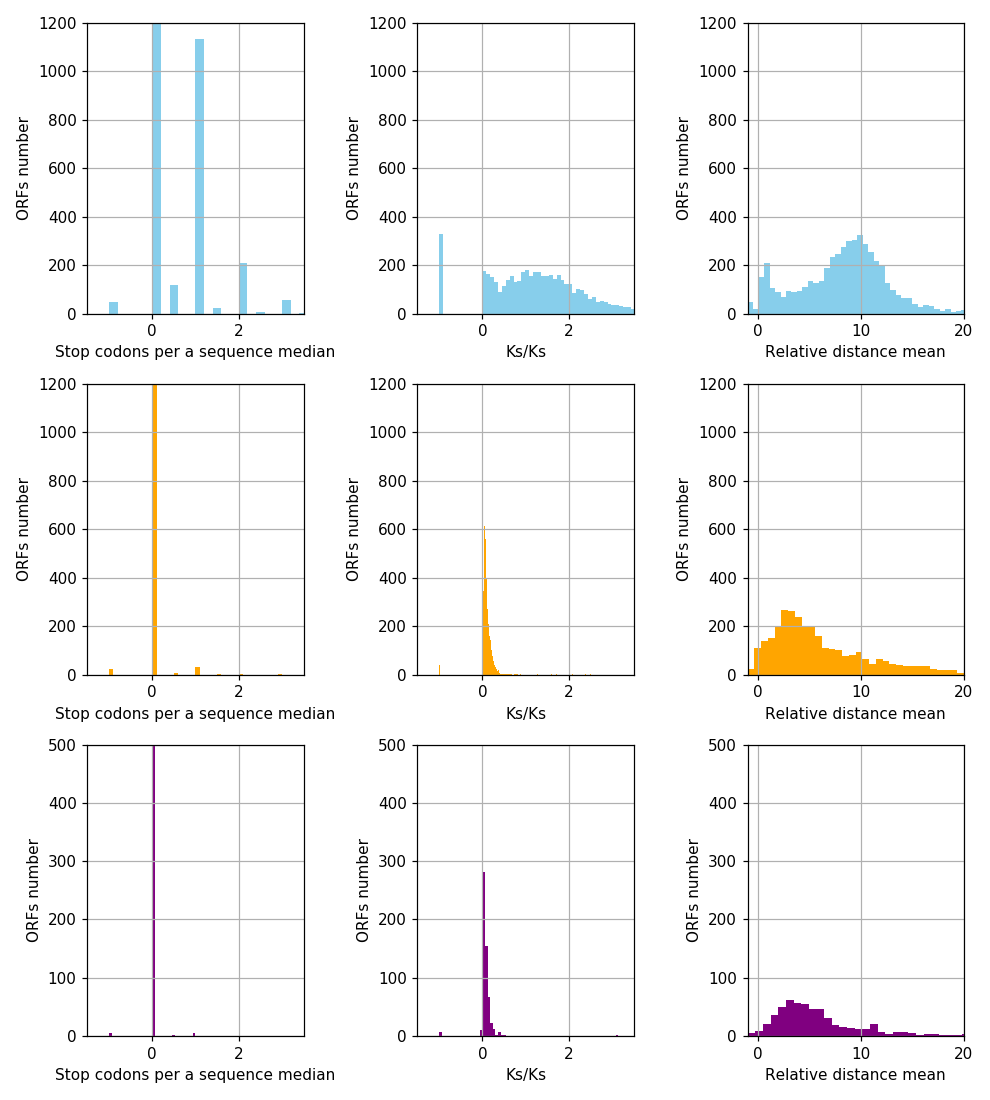

In [50]:
fig = plt.figure(figsize=(9, 10))

x11, x12 = -1.5, 3.5
y1, y2 = 0, 1200
y_ess = 500
x21, x22 = -1.5, 3.5
x31, x32 = -1.0, 20.0
x1_label = "Stop codons per a sequence median"
x2_label = "Ks/Ks"
x3_label = "Relative distance mean"
y_label = "ORFs number"

ax1 = fig.add_subplot(331)
ax1 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "other"]["stops_per_seq_median"].hist(bins=50, color=OTHER_COLOR)
ax1.set_xlabel(x1_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x11, x12)
ax1.set_ylim(y1, y2)

ax4 = fig.add_subplot(334)
ax4 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "advantageous"]["stops_per_seq_median"].hist(bins=40, color=ADV_COLOR)
ax4.set_xlabel(x1_label)
ax4.set_ylabel(y_label)
ax4.set_xlim(x11, x12)
ax4.set_ylim(y1, y2)

ax7 = fig.add_subplot(337)
ax7 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "essential"]["stops_per_seq_median"].hist(bins=30, color=ESS_COLOR)
ax7.set_xlabel(x1_label)
ax7.set_ylabel(y_label)
ax7.set_xlim(x11, x12)
ax7.set_ylim(y1, y_ess)

ax2 = fig.add_subplot(332)
ax2 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "other"]["Ka/Ks"].hist(bins=120, color=OTHER_COLOR)
ax2.set_xlabel(x2_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x21, x22)
ax2.set_ylim(y1, y2)

ax5 = fig.add_subplot(335)
ax5 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "advantageous"]["Ka/Ks"].hist(bins=150, color=ADV_COLOR)
ax5.set_xlabel(x2_label)
ax5.set_ylabel(y_label)
ax5.set_xlim(x21, x22)
ax5.set_ylim(y1, y2)

ax8 = fig.add_subplot(338)
ax8 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "essential"]["Ka/Ks"].hist(bins=70, color=ESS_COLOR)
ax8.set_xlabel(x2_label)
ax8.set_ylabel(y_label)
ax8.set_xlim(x21, x22)
ax8.set_ylim(y1, y_ess)

ax3 = fig.add_subplot(333)
ax3 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "other"]["relative_mean_btax_dist"].hist(bins=180, color=OTHER_COLOR)
ax3.set_xlabel(x3_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x31, x32)
ax3.set_ylim(y1, y2)

ax6 = fig.add_subplot(336)
ax6 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "advantageous"]["relative_mean_btax_dist"].hist(bins=120, color=ADV_COLOR)
ax6.set_xlabel(x3_label)
ax6.set_ylabel(y_label)
ax6.set_xlim(x31, x32)
ax6.set_ylim(y1, y2)

ax9 = fig.add_subplot(339)
ax9 = rev2h_gtf_df[rev2h_gtf_df["annot_group"] == "essential"]["relative_mean_btax_dist"].hist(bins=80, color=ESS_COLOR)
ax9.set_xlabel(x3_label)
ax9.set_ylabel(y_label)
ax9.set_xlim(x31, x32)
ax9.set_ylim(y1, y_ess)

fig.tight_layout()

<IPython.core.display.Javascript object>


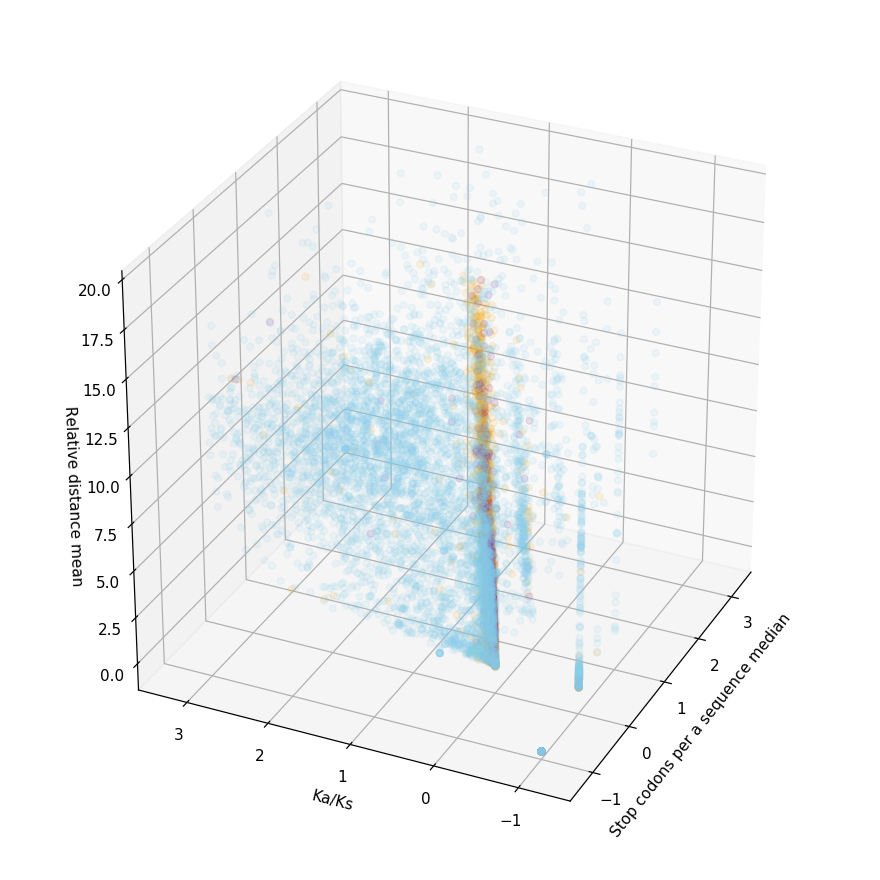

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipyke

In [55]:
alpha = 0.1
ssm_1, ssm_2 = -1.5, 3.5
kaks_1, kaks_2 = -1.5, 3.5
rmd_1, rmd_2 = -1.0, 20.0
kaks_gtf_df = gtf_df[gtf_df["Ka/Ks"] >= kaks_1][gtf_df["Ka/Ks"] <= kaks_2]
query = ("stops_per_seq_median >= {ssm_1} & stops_per_seq_median <= {ssm_2} & "
         "relative_mean_btax_dist >= {rmd_1} & relative_mean_btax_dist <= {rmd_2}").format(ssm_1=ssm_1, ssm_2=ssm_2,
                                                                                           rmd_1=rmd_1, rmd_2=rmd_2)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["stops_per_seq_median"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["Ka/Ks"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["relative_mean_btax_dist"],
           c=OTHER_COLOR,
           alpha=alpha)

ax.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["stops_per_seq_median"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["Ka/Ks"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["relative_mean_btax_dist"],
           c=ADV_COLOR,
           alpha=alpha)

ax.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["stops_per_seq_median"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["Ka/Ks"],
           kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["relative_mean_btax_dist"],
           c=ESS_COLOR,
           alpha=alpha)

ax.set_xlabel("Stop codons per a sequence median")
ax.set_ylabel("Ka/Ks")
ax.set_zlabel("Relative distance mean")
ax.set_xlim(ssm_1, ssm_2)
ax.set_ylim(kaks_1, kaks_2)
ax.set_zlim(rmd_1, rmd_2)

fig.tight_layout()

In [48]:
# t-SNE
tsne = TSNE(n_components=3)

if FRAME_REV2_HANDLE == 0:
    tsne_gtf_df = pd.concat((gtf_df[["seqid", "start", "end", "strand", "annot_group"]], pd.DataFrame(tsne.fit_transform(sf_gtf_df), columns=["tsne1", "tsne2", "tsne3"])), axis=1)
elif FRAME_REV2_HANDLE == 1:
    tsne_gtf_df = pd.concat((gtf_df[["seqid", "start", "end", "strand", "annot_group"]], pd.DataFrame(tsne.fit_transform(sf_gtf_df), columns=["tsne1", "tsne2", "tsne3"])), axis=1)[~gtf_df["frame_rev2"]].reset_index(drop=True)
elif FRAME_REV2_HANDLE == 2:
    tsne_gtf_df = pd.concat((gtf_df[~gtf_df["frame_rev2"]].reset_index(drop=True)[["seqid", "start", "end", "strand", "annot_group"]], pd.DataFrame(tsne.fit_transform(sf_gtf_df[~gtf_df["frame_rev2"]]), columns=["tsne1", "tsne2", "tsne3"])), axis=1)  

<IPython.core.display.Javascript object>


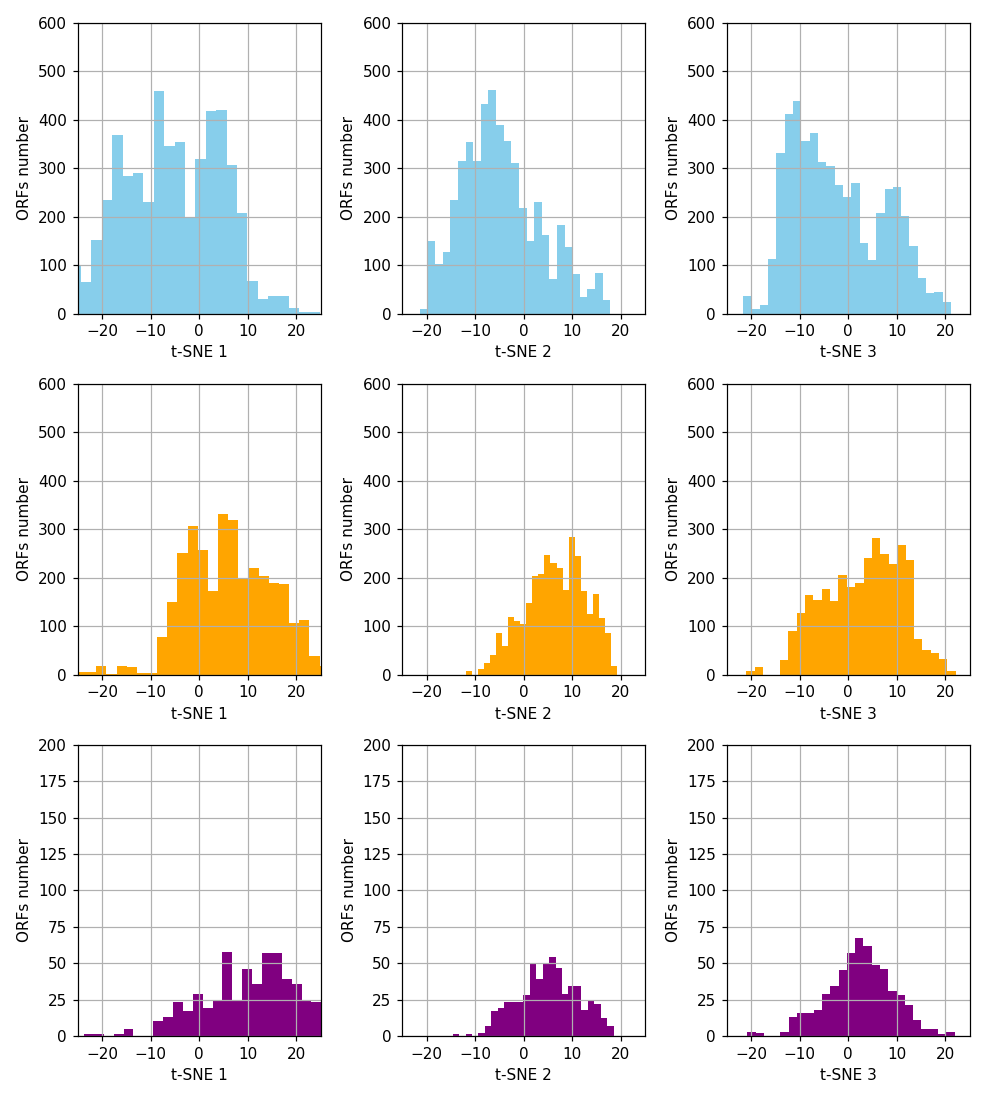

In [51]:
fig = plt.figure(figsize=(9, 10))

x11, x12 = -25.0, 25.0
y1, y2 = 0, 600
y_ess = 200
x21, x22 = -25.0, 25.0
x31, x32 = -25.0, 25.0
x1_label = "t-SNE 1"
x2_label = "t-SNE 2"
x3_label = "t-SNE 3"
y_label = "ORFs number"

ax1 = fig.add_subplot(331)
ax1 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "other"]["tsne1"].hist(bins=25, color=OTHER_COLOR)
ax1.set_xlabel(x1_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x11, x12)
ax1.set_ylim(y1, y2)

ax4 = fig.add_subplot(334)
ax4 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "advantageous"]["tsne1"].hist(bins=25, color=ADV_COLOR)
ax4.set_xlabel(x1_label)
ax4.set_ylabel(y_label)
ax4.set_xlim(x11, x12)
ax4.set_ylim(y1, y2)

ax7 = fig.add_subplot(337)
ax7 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "essential"]["tsne1"].hist(bins=25, color=ESS_COLOR)
ax7.set_xlabel(x1_label)
ax7.set_ylabel(y_label)
ax7.set_xlim(x11, x12)
ax7.set_ylim(y1, y_ess)

ax2 = fig.add_subplot(332)
ax2 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "other"]["tsne2"].hist(bins=25, color=OTHER_COLOR)
ax2.set_xlabel(x2_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x21, x22)
ax2.set_ylim(y1, y2)

ax5 = fig.add_subplot(335)
ax5 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "advantageous"]["tsne2"].hist(bins=25, color=ADV_COLOR)
ax5.set_xlabel(x2_label)
ax5.set_ylabel(y_label)
ax5.set_xlim(x21, x22)
ax5.set_ylim(y1, y2)

ax8 = fig.add_subplot(338)
ax8 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "essential"]["tsne2"].hist(bins=25, color=ESS_COLOR)
ax8.set_xlabel(x2_label)
ax8.set_ylabel(y_label)
ax8.set_xlim(x21, x22)
ax8.set_ylim(y1, y_ess)

ax3 = fig.add_subplot(333)
ax3 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "other"]["tsne3"].hist(bins=25, color=OTHER_COLOR)
ax3.set_xlabel(x3_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x31, x32)
ax3.set_ylim(y1, y2)

ax6 = fig.add_subplot(336)
ax6 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "advantageous"]["tsne3"].hist(bins=25, color=ADV_COLOR)
ax6.set_xlabel(x3_label)
ax6.set_ylabel(y_label)
ax6.set_xlim(x31, x32)
ax6.set_ylim(y1, y2)

ax9 = fig.add_subplot(339)
ax9 = tsne_gtf_df[tsne_gtf_df["annot_group"] == "essential"]["tsne3"].hist(bins=25, color=ESS_COLOR)
ax9.set_xlabel(x3_label)
ax9.set_ylabel(y_label)
ax9.set_xlim(x31, x32)
ax9.set_ylim(y1, y_ess)

fig.tight_layout()

<IPython.core.display.Javascript object>


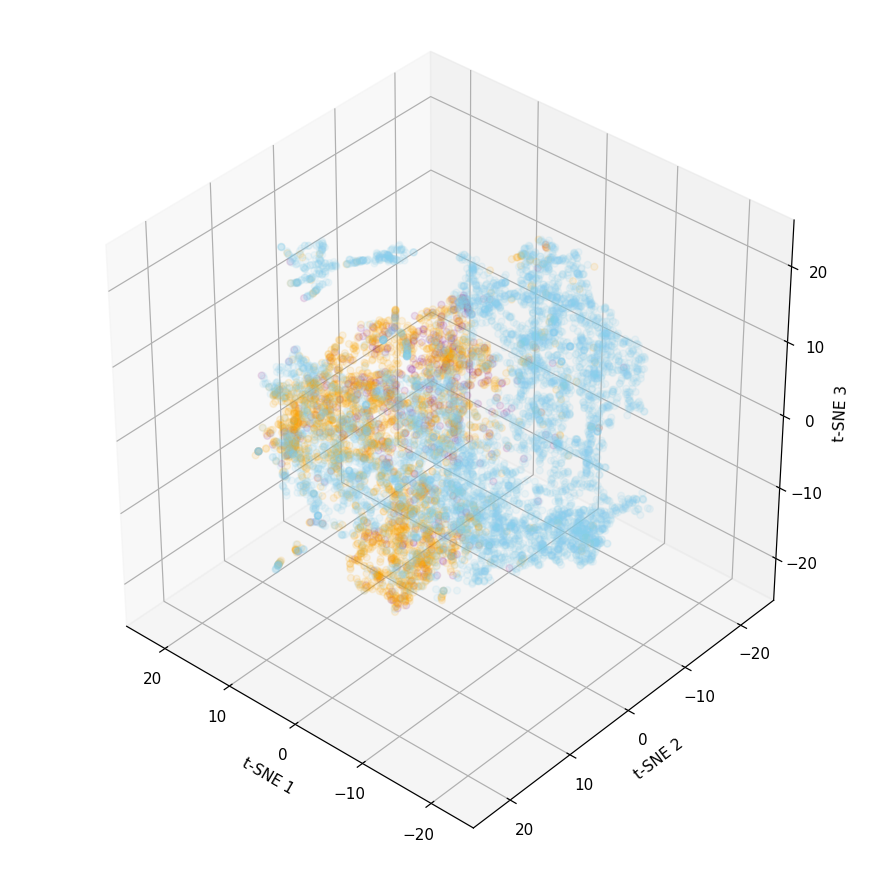

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-pack

In [58]:
alpha = 0.1
tsne1_1, tsne1_2 = -25.0, 25.0
tsne2_1, tsne2_2 = -25.0, 25.0
tsne3_1, tsne3_2 = -25.0, 25.0
tsne_query = ("tsne1 >= {tsne1_1} & tsne1 <= {tsne1_2} & "
              "tsne2 >= {tsne2_1} & tsne2 <= {tsne2_2} & "
              "tsne3 >= {tsne3_1} & tsne3 <= {tsne3_2}").format(tsne1_1=tsne1_1, tsne1_2=tsne1_2,
                                                                tsne2_1=tsne2_1, tsne2_2=tsne2_2,
                                                                tsne3_1=tsne3_1, tsne3_2=tsne3_2)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne1"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne2"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne3"],
           c=OTHER_COLOR,
           alpha=alpha)

ax.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne1"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne2"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne3"],
           c=ADV_COLOR,
           alpha=alpha)

ax.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne1"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne2"],
           tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne3"],
           c=ESS_COLOR,
           alpha=alpha)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_xlim(tsne1_1, tsne1_2)
ax.set_ylim(tsne2_1, tsne2_2)
ax.set_zlim(tsne3_1, tsne3_2)

fig.tight_layout()

<IPython.core.display.Javascript object>


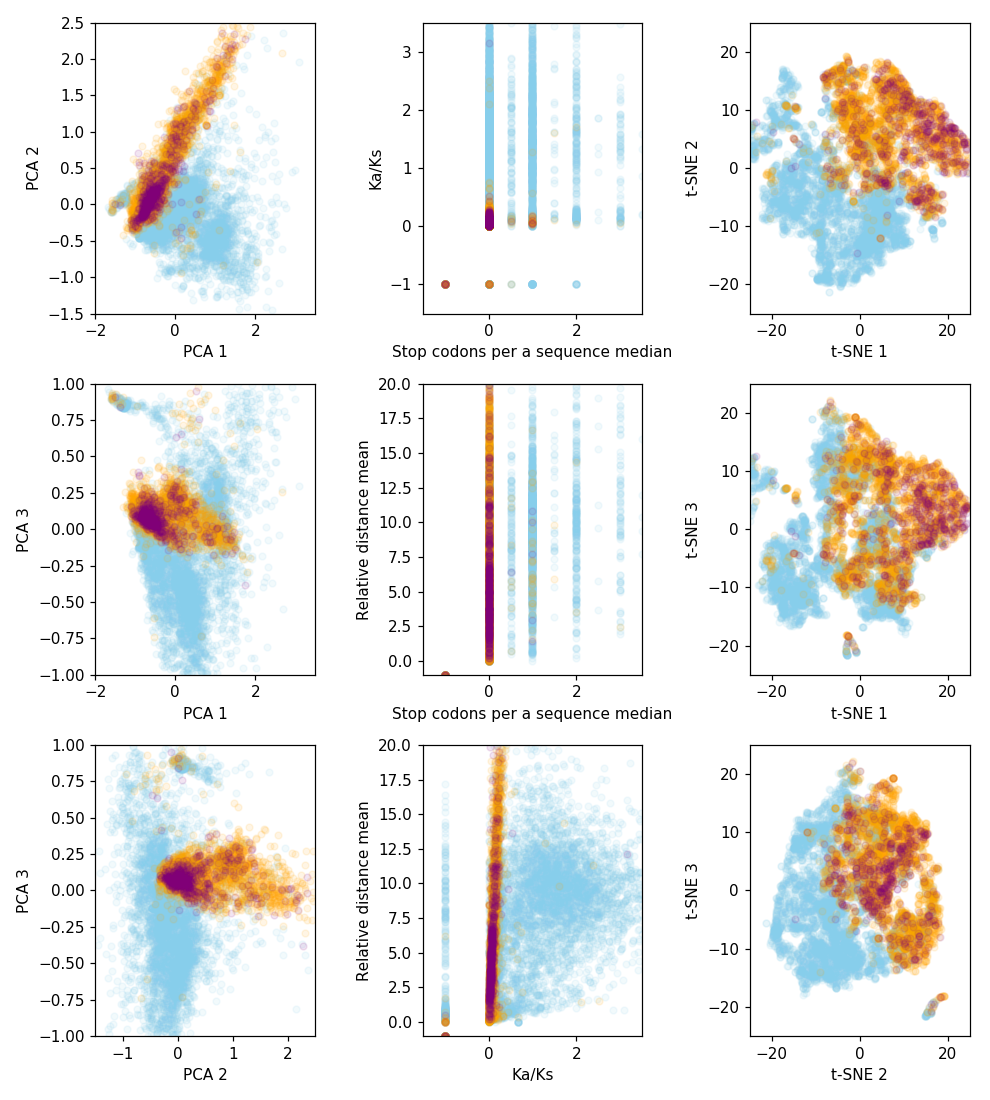

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be r

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:251: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [56]:
alpha = 0.1
marker_s = 20.0
# PCA params
pca1_1, pca1_2 = -2.0, 3.5
pca2_1, pca2_2 = -1.5, 2.5
pca3_1, pca3_2 = -1.0, 1.0
pca_query = ("pca1 >= {pca1_1} & pca1 <= {pca1_2} & " 
             "pca2 >= {pca2_1} & pca2 <= {pca2_2} & " 
             "pca3 >= {pca3_1} & pca3 <= {pca3_2}").format(pca1_1=pca1_1, pca1_2=pca1_2,
                                                           pca2_1=pca2_1, pca2_2=pca2_2,
                                                           pca3_1=pca3_1, pca3_2=pca3_2)

# EAGLE features
ssm_1, ssm_2 = -1.5, 3.5
kaks_1, kaks_2 = -1.5, 3.5
rmd_1, rmd_2 = -1.0, 20.0
kaks_gtf_df = gtf_df[gtf_df["Ka/Ks"] >= kaks_1][gtf_df["Ka/Ks"] <= kaks_2]
query = ("stops_per_seq_median >= {ssm_1} & stops_per_seq_median <= {ssm_2} & "
         "relative_mean_btax_dist >= {rmd_1} & relative_mean_btax_dist <= {rmd_2}").format(ssm_1=ssm_1, ssm_2=ssm_2,
                                                                                           rmd_1=rmd_1, rmd_2=rmd_2)

# t-SNE params
tsne1_1, tsne1_2 = -25.0, 25.0
tsne2_1, tsne2_2 = -25.0, 25.0
tsne3_1, tsne3_2 = -25.0, 25.0
tsne_query = ("tsne1 >= {tsne1_1} & tsne1 <= {tsne1_2} & "
              "tsne2 >= {tsne2_1} & tsne2 <= {tsne2_2} & "
              "tsne3 >= {tsne3_1} & tsne3 <= {tsne3_2}").format(tsne1_1=tsne1_1, tsne1_2=tsne1_2,
                                                                tsne2_1=tsne2_1, tsne2_2=tsne2_2,
                                                                tsne3_1=tsne3_1, tsne3_2=tsne3_2)

fig = plt.figure(figsize=(9, 10))

# PCA column
ax1 = fig.add_subplot(331)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca2"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca2"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca2"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_xlim(pca1_1, pca1_2)
ax1.set_ylim(pca2_1, pca2_2)

ax4 = fig.add_subplot(334)

ax4.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax4.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax4.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax4.set_xlabel("PCA 1")
ax4.set_ylabel("PCA 3")
ax4.set_xlim(pca1_1, pca1_2)
ax4.set_ylim(pca3_1, pca3_2)

ax7 = fig.add_subplot(337)

ax7.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax7.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax7.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax7.set_xlabel("PCA 2")
ax7.set_ylabel("PCA 3")
ax7.set_xlim(pca2_1, pca2_2)
ax7.set_ylim(pca3_1, pca3_2)

# EAGLE features column
ax2 = fig.add_subplot(332)

ax2.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["Ka/Ks"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax2.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["Ka/Ks"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax2.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["Ka/Ks"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax2.set_xlabel("Stop codons per a sequence median")
ax2.set_ylabel("Ka/Ks")
ax2.set_xlim(ssm_1, ssm_2)
ax2.set_ylim(kaks_1, kaks_2)

ax5 = fig.add_subplot(335)

ax5.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["relative_mean_btax_dist"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax5.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["relative_mean_btax_dist"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax5.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["stops_per_seq_median"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["relative_mean_btax_dist"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax5.set_xlabel("Stop codons per a sequence median")
ax5.set_ylabel("Relative distance mean")
ax5.set_xlim(ssm_1, ssm_2)
ax5.set_ylim(rmd_1, rmd_2)

ax8 = fig.add_subplot(338)

ax8.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["Ka/Ks"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "other"]["relative_mean_btax_dist"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax8.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["Ka/Ks"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "advantageous"]["relative_mean_btax_dist"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax8.scatter(kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["Ka/Ks"],
            kaks_gtf_df.query(query)[kaks_gtf_df["annot_group"] == "essential"]["relative_mean_btax_dist"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax8.set_xlabel("Ka/Ks")
ax8.set_ylabel("Relative distance mean")
ax8.set_xlim(kaks_1, kaks_2)
ax8.set_ylim(rmd_1, rmd_2)

# t-SNE column
ax3 = fig.add_subplot(333)

ax3.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne2"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax3.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne2"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax3.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne2"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax3.set_xlabel("t-SNE 1")
ax3.set_ylabel("t-SNE 2")
ax3.set_xlim(tsne1_1, tsne1_2)
ax3.set_ylim(tsne2_1, tsne2_2)

ax6 = fig.add_subplot(336)

ax6.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax6.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax6.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne1"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax6.set_xlabel("t-SNE 1")
ax6.set_ylabel("t-SNE 3")
ax6.set_xlim(tsne1_1, tsne1_2)
ax6.set_ylim(tsne3_1, tsne3_2)

ax9 = fig.add_subplot(339)

ax9.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne2"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "other"]["tsne3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax9.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne2"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "advantageous"]["tsne3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax9.scatter(tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne2"],
            tsne_gtf_df.query(tsne_query)[tsne_gtf_df["annot_group"] == "essential"]["tsne3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax9.set_xlabel("t-SNE 2")
ax9.set_ylabel("t-SNE 3")
ax9.set_xlim(tsne2_1, tsne2_2)
ax9.set_ylim(tsne3_1, tsne3_2)

fig.tight_layout()

## Clusterization

In [126]:
# K-Means
kmeans = KMeans(n_clusters=20).fit(rev2h_sf_gtf_df)
pca_gtf_df["kmeans"] = pd.Series(kmeans.labels_)
rev2h_gtf_df["kmeans"] = pd.Series(kmeans.labels_)
tsne_gtf_df["kmeans"] = pd.Series(kmeans.labels_)

<IPython.core.display.Javascript object>


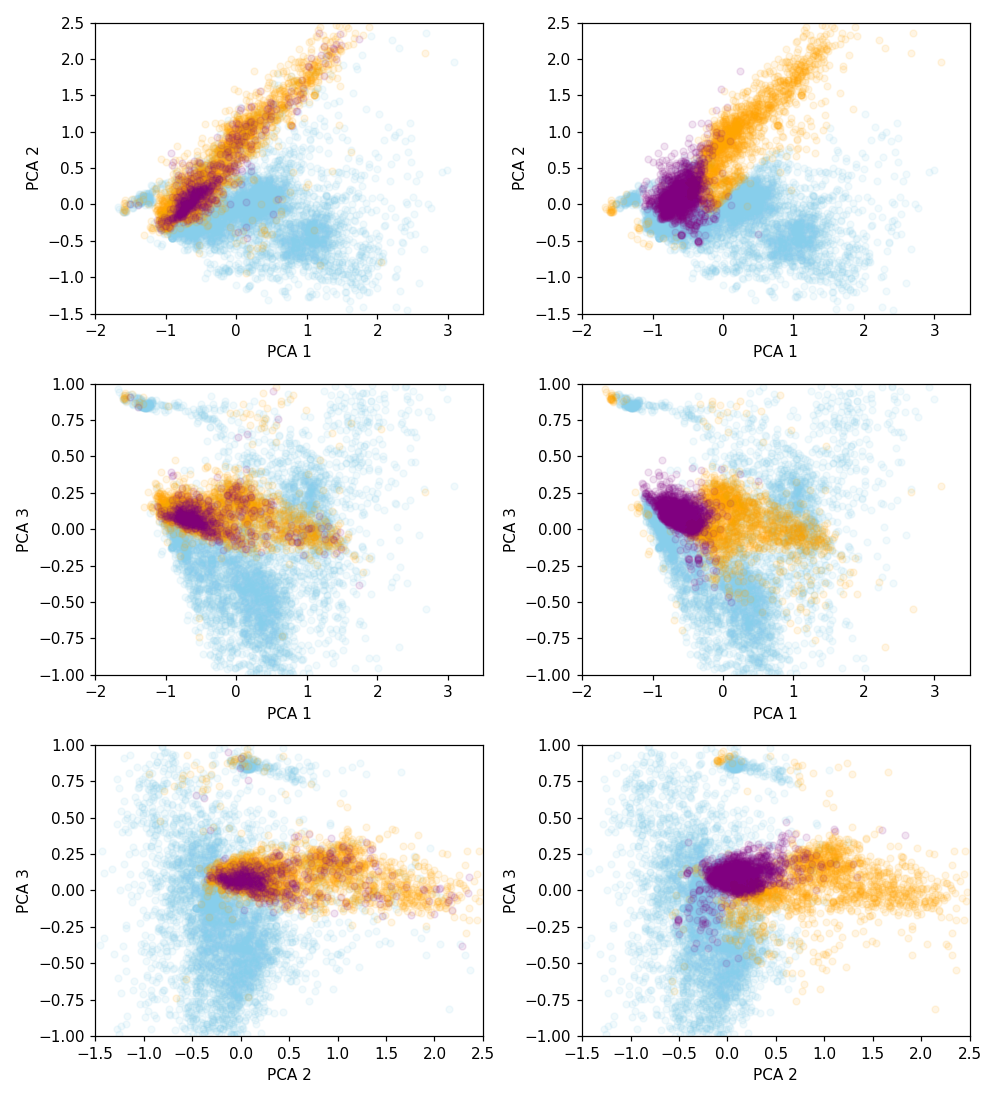

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be r

In [182]:
# K-Means PCA
alpha = 0.1
marker_s = 20.0

pca1_1, pca1_2 = -2.0, 3.5
pca2_1, pca2_2 = -1.5, 2.5
pca3_1, pca3_2 = -1.0, 1.0
pca_query = ("pca1 >= {pca1_1} & pca1 <= {pca1_2} & " 
             "pca2 >= {pca2_1} & pca2 <= {pca2_2} & " 
             "pca3 >= {pca3_1} & pca3 <= {pca3_2}").format(pca1_1=pca1_1, pca1_2=pca1_2,
                                                           pca2_1=pca2_1, pca2_2=pca2_2,
                                                           pca3_1=pca3_1, pca3_2=pca3_2)

fig = plt.figure(figsize=(9, 10))

# annotated clusters
ax1 = fig.add_subplot(321)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca2"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca2"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax1.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca2"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_xlim(pca1_1, pca1_2)
ax1.set_ylim(pca2_1, pca2_2)

ax3 = fig.add_subplot(323)

ax3.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax3.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax3.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax3.set_xlabel("PCA 1")
ax3.set_ylabel("PCA 3")
ax3.set_xlim(pca1_1, pca1_2)
ax3.set_ylim(pca3_1, pca3_2)

ax5 = fig.add_subplot(325)

ax5.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "other"]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax5.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "advantageous"]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax5.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["annot_group"] == "essential"]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax5.set_xlabel("PCA 2")
ax5.set_ylabel("PCA 3")
ax5.set_xlim(pca2_1, pca2_2)
ax5.set_ylim(pca3_1, pca3_2)

# predicted clusters
adv_clust_nums = (3, 4, 5, 9, 10, 17)
ess_clust_nums = (1, 15)

ax2 = fig.add_subplot(322)

ax2.scatter(pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca2"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax2.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca2"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)


ax2.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca2"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_xlim(pca1_1, pca1_2)
ax2.set_ylim(pca2_1, pca2_2)

ax4 = fig.add_subplot(324)

ax4.scatter(pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax4.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax4.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca1"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax4.set_xlabel("PCA 1")
ax4.set_ylabel("PCA 3")
ax4.set_xlim(pca1_1, pca1_2)
ax4.set_ylim(pca3_1, pca3_2)

ax6 = fig.add_subplot(326)

ax6.scatter(pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca2"],
            pca_gtf_df.query(pca_query)[~pca_gtf_df["kmeans"].isin(adv_clust_nums + ess_clust_nums)]["pca3"],
            s=marker_s,
            c=OTHER_COLOR,
            alpha=alpha)

ax6.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(adv_clust_nums)]["pca3"],
            s=marker_s,
            c=ADV_COLOR,
            alpha=alpha)

ax6.scatter(pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca2"],
            pca_gtf_df.query(pca_query)[pca_gtf_df["kmeans"].isin(ess_clust_nums)]["pca3"],
            s=marker_s,
            c=ESS_COLOR,
            alpha=alpha)

ax6.set_xlabel("PCA 2")
ax6.set_ylabel("PCA 3")
ax6.set_xlim(pca2_1, pca2_2)
ax6.set_ylim(pca3_1, pca3_2)

fig.tight_layout()

In [176]:
# accuracy estimation
TP_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"][pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
TN_ess = pca_gtf_df[pca_gtf_df["annot_group"] != "essential"][~pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
FP_ess = pca_gtf_df[pca_gtf_df["annot_group"] != "essential"][pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
FN_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"][~pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
print(TP_ess, FN_ess)
print(FP_ess, TN_ess)
recall = float(TP_ess) / float(TP_ess+FN_ess)
precision = float(TP_ess) / float(TP_ess+FP_ess)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))
TP_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"][pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
TN_adv = pca_gtf_df[pca_gtf_df["annot_group"] != "advantageous"][~pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
FP_adv = pca_gtf_df[pca_gtf_df["annot_group"] != "advantageous"][pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
FN_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"][~pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
print(TP_adv, FN_adv)
print(FP_adv, TN_adv)
recall = float(TP_adv) / float(TP_adv+FN_adv)
precision = float(TP_adv) / float(TP_adv+FP_adv)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))

(349, 216)
(1628, 6563)
recall: 0.617699115044
precision: 0.176530096105
F1 score: 0.274586939418
(1157, 2052)
(533, 5014)
recall: 0.360548457463
precision: 0.684615384615
F1 score: 0.472341294142


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/media/denis/Data/Data/Bioinf/Projects/Annota

In [183]:
# soft accuracy estimation
soft_TP_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"][pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
soft_TN_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
soft_FP_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][pca_gtf_df["kmeans"].isin(ess_clust_nums)].shape[0]
soft_FN_ess = pca_gtf_df[pca_gtf_df["annot_group"] == "essential"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
print(soft_TP_ess, soft_FN_ess)
print(soft_FP_ess, soft_TN_ess)
recall = float(soft_TP_ess) / float(soft_TP_ess+soft_FN_ess)
precision = float(soft_TP_ess) / float(soft_TP_ess+soft_FP_ess)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))
soft_TP_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"][pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
soft_TN_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
soft_FP_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][pca_gtf_df["kmeans"].isin(adv_clust_nums)].shape[0]
soft_FN_adv = pca_gtf_df[pca_gtf_df["annot_group"] == "advantageous"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
print(soft_TP_adv, soft_FN_adv)
print(soft_FP_adv, soft_TN_adv)
recall = float(soft_TP_adv) / float(soft_TP_adv+soft_FN_adv)
precision = float(soft_TP_adv) / float(soft_TP_adv+soft_FP_adv)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))

(349, 58)
(146, 4452)
recall: 0.857493857494
precision: 0.705050505051
F1 score: 0.773835920177
(1167, 560)
(384, 4452)
recall: 0.675738274464
precision: 0.752417794971
F1 score: 0.7120195241


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/media/denis/Data/Data/Bioinf/Projects/Annota

In [184]:
# fuctionality accuracy estimation
TP_func = pca_gtf_df[pca_gtf_df["annot_group"] != "other"][pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
TN_func = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
FP_func = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
FN_func = pca_gtf_df[pca_gtf_df["annot_group"] != "other"][~pca_gtf_df["kmeans"].isin(ess_clust_nums + adv_clust_nums)].shape[0]
print(TP_func, FN_func)  # recall = 0.795
print(FP_func, TN_func)  # precision = 0.718
recall = float(TP_func) / float(TP_func+FN_func)
precision = float(TP_func) / float(TP_func+FP_func)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))

(3156, 618)
(530, 4452)
recall: 0.836248012719
precision: 0.85621269669
F1 score: 0.846112600536


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [185]:
# GeneMarkS2 accuracy estimation
intersect_thr = 0.75
gms2_TP = pca_gtf_df[pca_gtf_df["annot_group"] != "other"][pca_gtf_df["gms2_annot"] >= intersect_thr].shape[0]
gms2_TN = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][pca_gtf_df["gms2_annot"] < intersect_thr].shape[0]
gms2_FP = pca_gtf_df[pca_gtf_df["annot_group"] == "other"][pca_gtf_df["gms2_annot"] >= intersect_thr].shape[0]
gms2_FN = pca_gtf_df[pca_gtf_df["annot_group"] != "other"][pca_gtf_df["gms2_annot"] < intersect_thr].shape[0]
print(gms2_TP, gms2_FN)
print(gms2_FP, gms2_TN)
recall = float(gms2_TP) / float(gms2_TP+gms2_FN)
precision = float(gms2_TP) / float(gms2_TP+gms2_FP)
print("recall: %s" % recall)
print("precision: %s" % precision)
print("F1 score: %s" % (2.0 * (recall*precision) / (recall+precision)))


(3741, 33)
(110, 4872)
recall: 0.991255961844
precision: 0.971435990652
F1 score: 0.981245901639


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_run_venv/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<IPython.core.display.Javascript object>


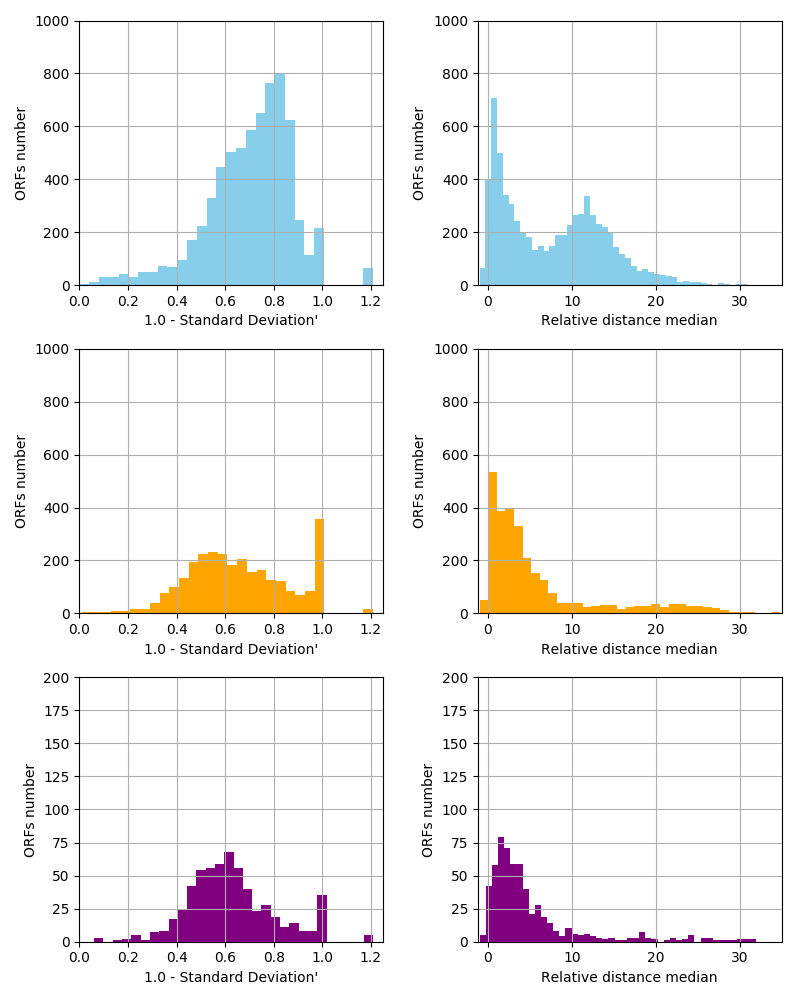

In [89]:
x1, x2 = 0.0, 1.25
y1, y2 = 0, 1000
y_ess = 200
x_left_label = "1.0 - Standard Deviation'"
x_right_label = "Relative distance median"
y_label = "ORFs number"

fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(321)
ax1 = gtf_df[gtf_df["annot_group"] == "other"]["uniformity_std"].hist(bins=30, color=OTHER_COLOR)
ax1.set_xlabel(x_left_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

ax3 = fig.add_subplot(323)
ax3 = gtf_df[gtf_df["annot_group"] == "advantageous"]["uniformity_std"].hist(bins=30, color=ADV_COLOR)
ax3.set_xlabel(x_left_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x1, x2)
ax3.set_ylim(y1, y2)

ax5 = fig.add_subplot(325)
ax5 = gtf_df[gtf_df["annot_group"] == "essential"]["uniformity_std"].hist(bins=30, color=ESS_COLOR)
ax5.set_xlabel(x_left_label)
ax5.set_ylabel(y_label)
ax5.set_xlim(x1, x2)
ax5.set_ylim(y1, y_ess)

x3, x4 = -1.2, 35.0

ax2 = fig.add_subplot(322)
ax2 = gtf_df[gtf_df["annot_group"] == "other"]["relative_median_btax_dist"].hist(bins=75, color=OTHER_COLOR)
ax2.set_xlabel(x_right_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x3, x4)
ax2.set_ylim(y1, y2)

ax4 = fig.add_subplot(324)
ax4 = gtf_df[gtf_df["annot_group"] == "advantageous"]["relative_median_btax_dist"].hist(bins=75, color=ADV_COLOR)
ax4.set_xlabel(x_right_label)
ax4.set_ylabel(y_label)
ax4.set_xlim(x3, x4)
ax4.set_ylim(y1, y2)

ax6 = fig.add_subplot(326)
ax6 = gtf_df[gtf_df["annot_group"] == "essential"]["relative_median_btax_dist"].hist(bins=45, color=ESS_COLOR)
ax6.set_xlabel(x_right_label)
ax6.set_ylabel(y_label)
ax6.set_xlim(x3, x4)
ax6.set_ylim(y1, y_ess)

fig.tight_layout()

<IPython.core.display.Javascript object>


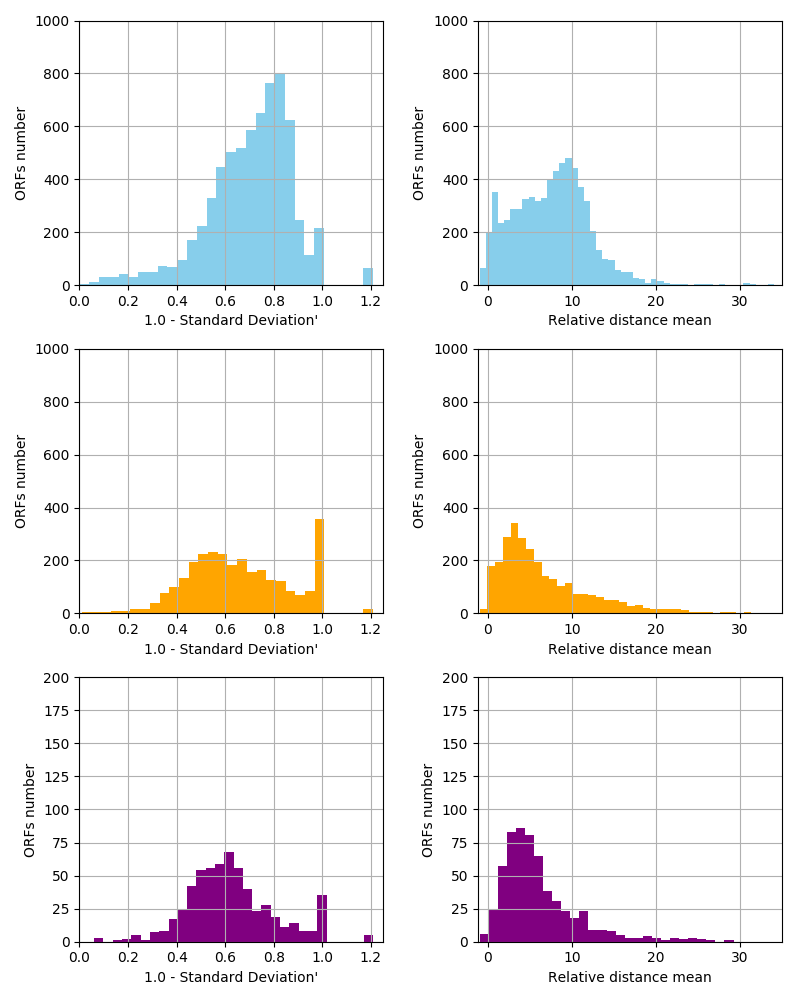

In [91]:
x1, x2 = 0.0, 1.25
y1, y2 = 0, 1000
y_ess = 200
x_left_label = "1.0 - Standard Deviation'"
x_right_label = "Relative distance mean"
y_label = "ORFs number"

fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(321)
ax1 = gtf_df[gtf_df["annot_group"] == "other"]["uniformity_std"].hist(bins=30, color=OTHER_COLOR)
ax1.set_xlabel(x_left_label)
ax1.set_ylabel(y_label)
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

ax3 = fig.add_subplot(323)
ax3 = gtf_df[gtf_df["annot_group"] == "advantageous"]["uniformity_std"].hist(bins=30, color=ADV_COLOR)
ax3.set_xlabel(x_left_label)
ax3.set_ylabel(y_label)
ax3.set_xlim(x1, x2)
ax3.set_ylim(y1, y2)

ax5 = fig.add_subplot(325)
ax5 = gtf_df[gtf_df["annot_group"] == "essential"]["uniformity_std"].hist(bins=30, color=ESS_COLOR)
ax5.set_xlabel(x_left_label)
ax5.set_ylabel(y_label)
ax5.set_xlim(x1, x2)
ax5.set_ylim(y1, y_ess)

x3, x4 = -1.2, 35.0

ax2 = fig.add_subplot(322)
ax2 = gtf_df[gtf_df["annot_group"] == "other"]["relative_mean_btax_dist"].hist(bins=250, color=OTHER_COLOR)
ax2.set_xlabel(x_right_label)
ax2.set_ylabel(y_label)
ax2.set_xlim(x3, x4)
ax2.set_ylim(y1, y2)

ax4 = fig.add_subplot(324)
ax4 = gtf_df[gtf_df["annot_group"] == "advantageous"]["relative_mean_btax_dist"].hist(bins=85, color=ADV_COLOR)
ax4.set_xlabel(x_right_label)
ax4.set_ylabel(y_label)
ax4.set_xlim(x3, x4)
ax4.set_ylim(y1, y2)

ax6 = fig.add_subplot(326)
ax6 = gtf_df[gtf_df["annot_group"] == "essential"]["relative_mean_btax_dist"].hist(bins=55, color=ESS_COLOR)
ax6.set_xlabel(x_right_label)
ax6.set_ylabel(y_label)
ax6.set_xlim(x3, x4)
ax6.set_ylim(y1, y_ess)

fig.tight_layout()

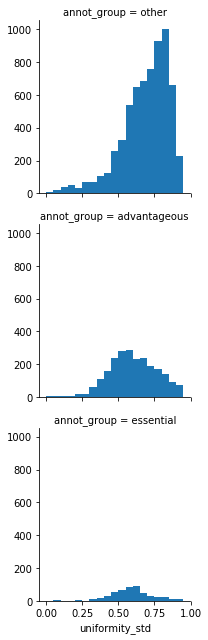

In [17]:
# %matplotlib inline
bins = np.arange(0.0, 1.0, 0.05)
h = sns.FacetGrid(gtf_df, row="annot_group")
h.map(plt.hist, "uniformity_std", bins=bins)

<IPython.core.display.Javascript object>


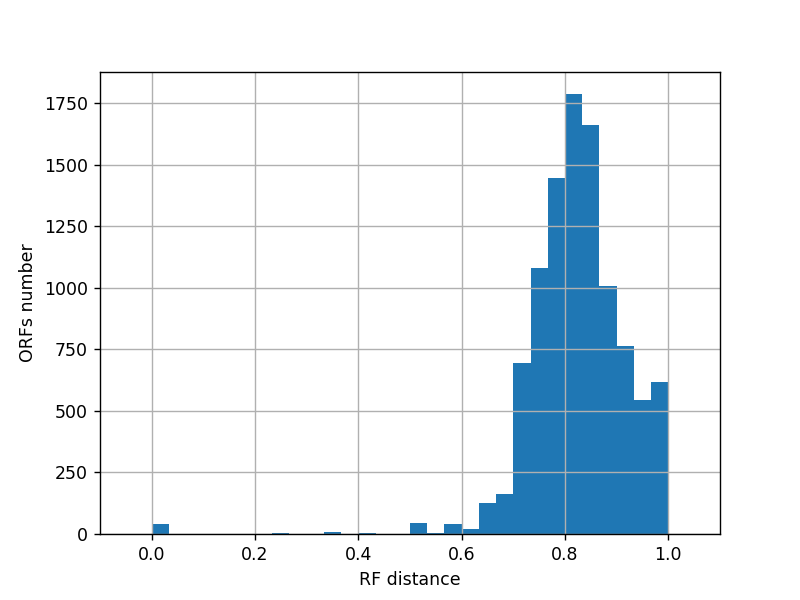

Text(0,0.5,'ORFs number')

In [103]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["phylo_diff"])).hist(bins=60);
ax.set_xlabel("RF distance")
ax.set_xlim(-0.1, 1.1)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


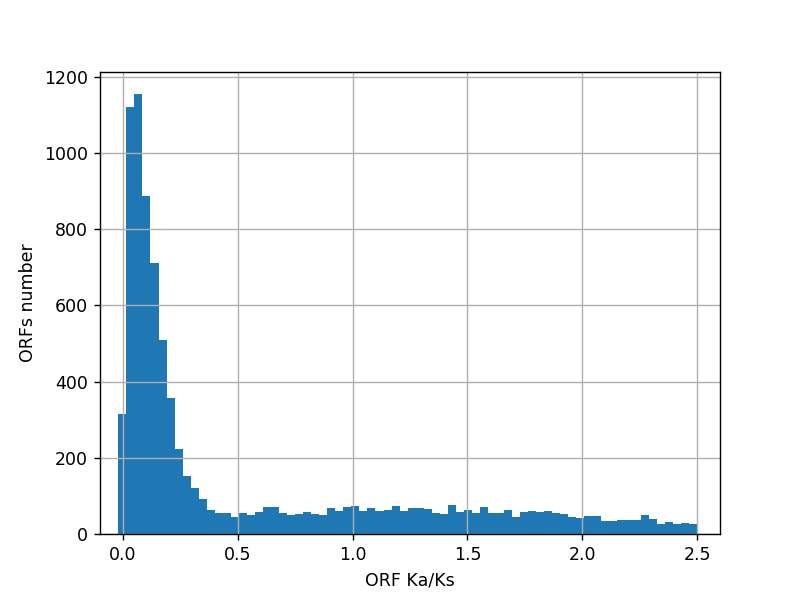

Text(0,0.5,'ORFs number')

In [104]:
ax = pd.Series(filter(lambda x: not np.isnan(x) and x <= 2.5, gtf_df["Ka/Ks"])).hist(bins=100);
ax.set_xlabel("ORF Ka/Ks")
ax.set_xlim(-0.1, 2.6)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

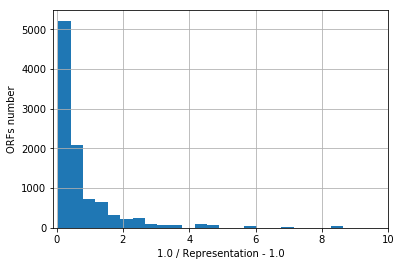

In [50]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["representation"])).hist(bins=60);
ax.set_xlabel("1.0 / Representation - 1.0")
ax.set_xlim(-0.1, 10.0)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

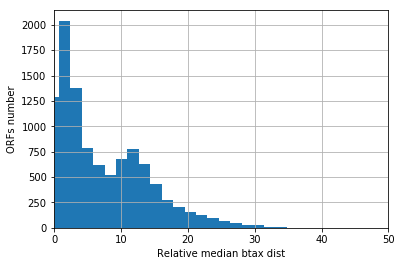

In [25]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["relative_median_btax_dist"])).hist(bins=45);
ax.set_xlabel("Relative median btax dist")
ax.set_xlim(-0.1, 50.0)
ax.set_ylabel("ORFs number")

Text(0,0.5,'RF distance')

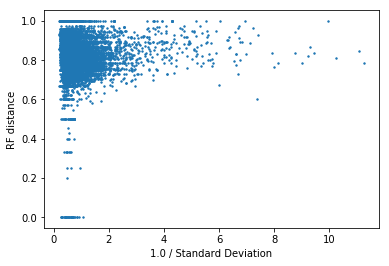

In [26]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("RF distance")

Text(0,0.5,'ORF length')

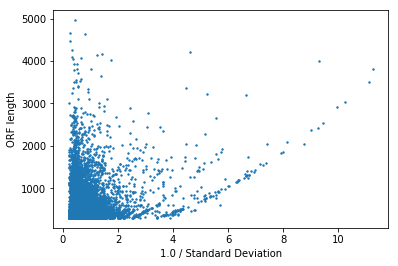

In [27]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

Text(0,0.5,'RF distance')

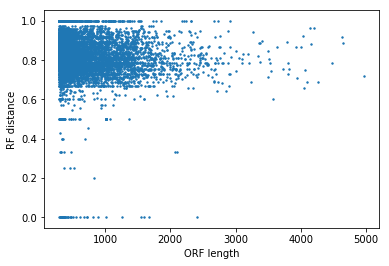

In [28]:
plt.scatter(x=nona_gtf_df["ORF_l"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("ORF length")
plt.ylabel("RF distance")

Text(0,0.5,'RF distance')

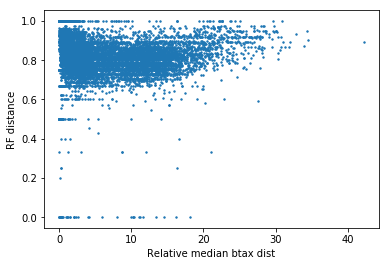

In [29]:
plt.scatter(x=nona_gtf_df["relative_median_btax_dist"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("Relative median btax dist")
plt.ylabel("RF distance")

Text(0,0.5,'1.0 / Representation - 1.0')

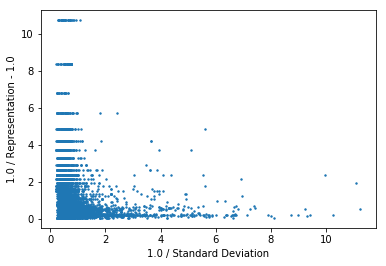

In [30]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

Text(0,0.5,'Relative median btax dist')

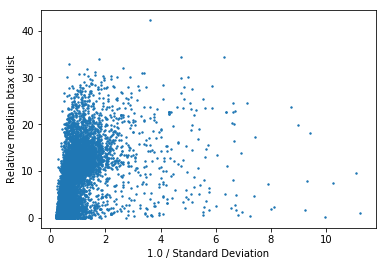

In [32]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

Text(0,0.5,'RF distance')

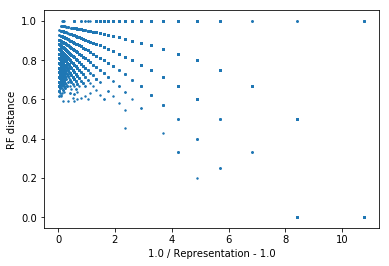

In [33]:
plt.scatter(x=nona_gtf_df["representation"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Representation - 1.0")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


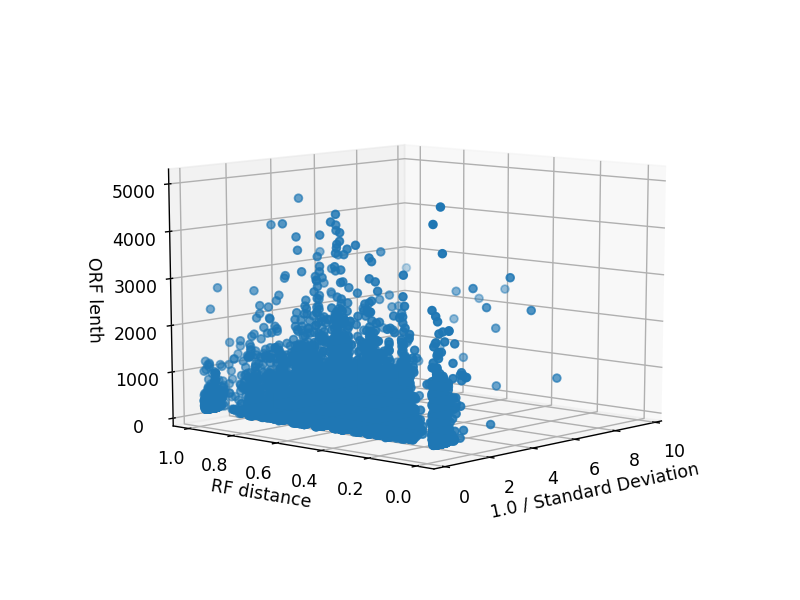

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nona_gtf_df["uniformity_std"],
           nona_gtf_df["phylo_diff"],
           nona_gtf_df["ORF_l"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("RF distance")
ax.set_zlabel("ORF lenth")
plt.show()

(2372, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


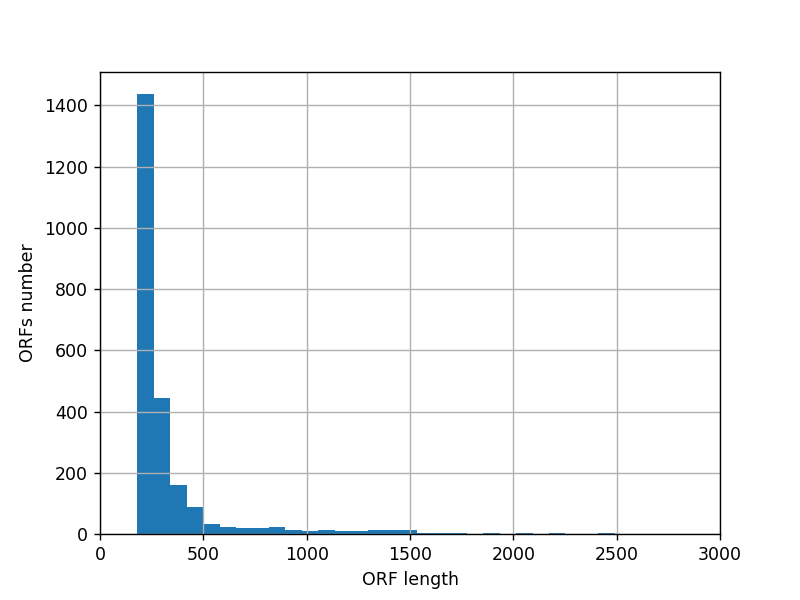

Text(0,0.5,'ORFs number')

In [109]:
gtf_df_filt1 = nona_gtf_df[nona_gtf_df["phylo_diff"] < 0.05][nona_gtf_df["uniformity_std"] < 2.0]
print(gtf_df_filt1.shape)
ax = gtf_df_filt1["ORF_l"].hist(bins=60)
ax.set_xlabel("ORF length")
ax.set_xlim(0, 3000)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


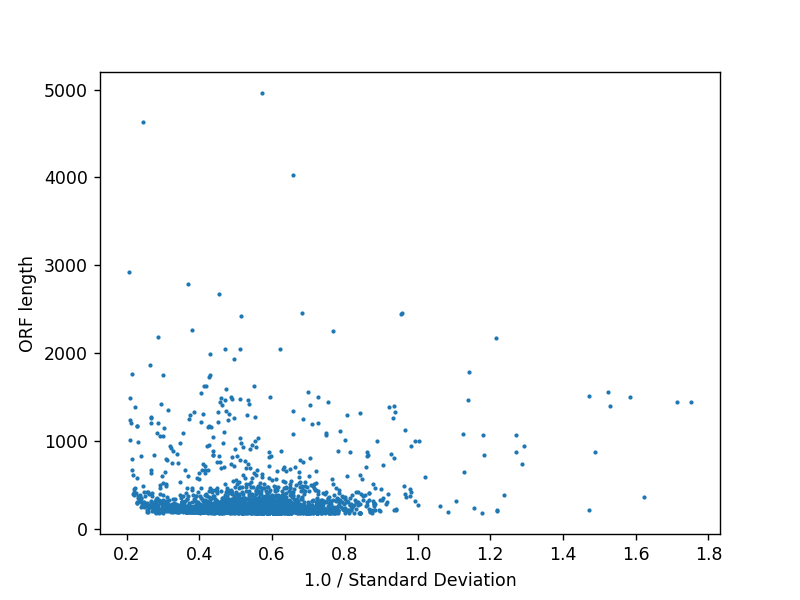

Text(0,0.5,'ORF length')

In [110]:
plt.scatter(x=gtf_df_filt1["uniformity_std"],
            y=gtf_df_filt1["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

Text(0,0.5,'1.0 / Representation - 1.0')

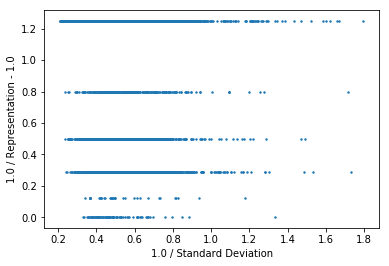

In [27]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

(1080, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


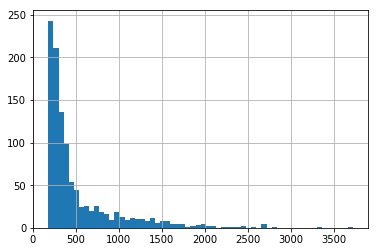

In [58]:
gtf_df_filt2 = gtf_df_filt[gtf_df_filt["representation"] < 0.4][gtf_df_filt["uniformity_std"] <= 1.3]
print(gtf_df_filt2.shape)
gtf_df_filt2["ORF_l"].hist(bins=60)

Text(0,0.5,'Relative median btax dist')

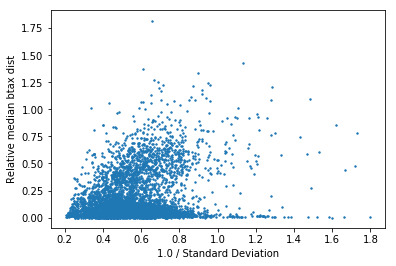

In [59]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

(447, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


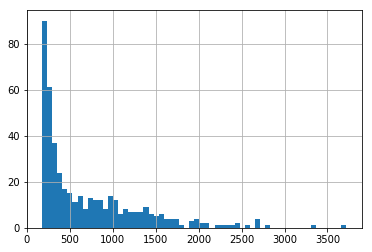

In [61]:
gtf_df_filt3 = gtf_df_filt2[gtf_df_filt["relative_median_btax_dist"] < 0.25][gtf_df_filt["uniformity_std"] <= 1.0]
print(gtf_df_filt3.shape)
gtf_df_filt3["ORF_l"].hist(bins=60)

<IPython.core.display.Javascript object>


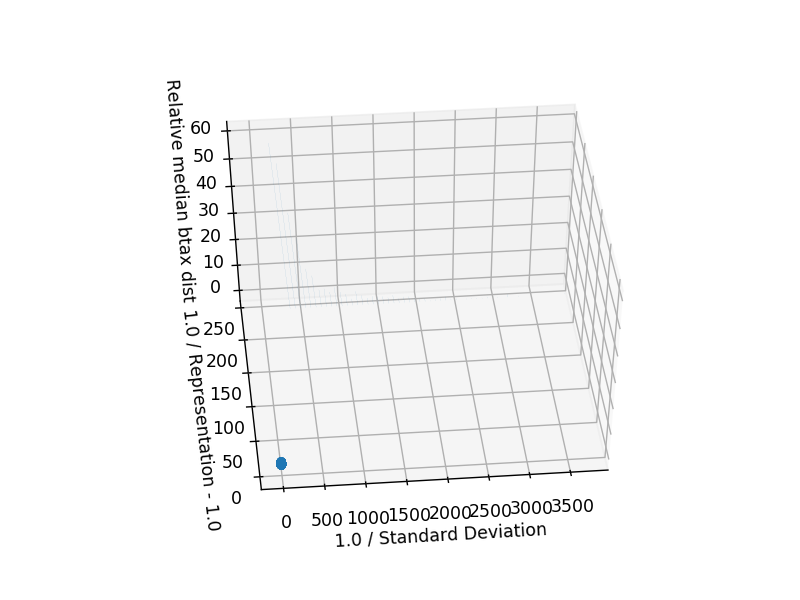

In [54]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gtf_df_filt2["uniformity_std"],
           gtf_df_filt2["representation"],
           gtf_df_filt2["relative_median_btax_dist"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("1.0 / Representation - 1.0")
ax.set_zlabel("Relative median btax dist")
plt.show()

In [19]:
1.0/ pd.Series([1,2,3,np.nan])

0    1.000000
1    0.500000
2    0.333333
3         NaN
dtype: float64

In [40]:
# ORFs alifnments by categories
ALL_ALNS_DIR = "../../../DEG/ECOLI_K12_orf_alignments"

OUT_DIR = "../../../DEG/ECOLI_K12_MG1655"
SUMMARY_TABLE_PATH = os.path.join(OUT_DIR, "summary_table.txt")
ESS_ALN_DIR = os.path.join(OUT_DIR, "ess_aln")
ADV_ALN_DIR = os.path.join(OUT_DIR, "adv_aln")
OTHER_ALN_DIR = os.path.join(OUT_DIR, "other_aln")

if not os.path.exists(ESS_ALN_DIR):
    os.makedirs(ESS_ALN_DIR)
if not os.path.exists(NONESS_ALN_DIR):
    os.makedirs(ADV_ALN_DIR)
if not os.path.exists(OTHER_ALN_DIR):
    os.makedirs(OTHER_ALN_DIR)

aln_info_list = list()
for aln_f_name in os.listdir(ALL_ALNS_DIR):
    aln_f_path = None
    aln_cat_path = None
    ori = None
    query = None
    aln_f_path = os.path.join(ALL_ALNS_DIR, aln_f_name)
    if os.path.isdir(aln_f_path):
        continue
    aln_name_list = aln_f_name.split("_")
    coords_list = aln_name_list[2].split("-")
    if coords_list[0][0] == "c":
        ori = "-"
        c_start = coords_list[1]
        c_end = coords_list[0][1:]
    else:
        ori = "+"
        c_start = coords_list[0]
        c_end = coords_list[1]
    query = 'seqid == "{seqid}" & start == {start} & end == {end} & strand == "{strand}"'.format(seqid="_".join(aln_name_list[:2]),
                                                                                                 start=c_start,
                                                                                                 end=c_end,
                                                                                                 strand=ori)
    orf_info = gtf_df.query(query).iloc[0]
    aln_cat = orf_info["annot_group"]
    if aln_cat == "essential":
        aln_cat_path = os.path.join(ESS_ALN_DIR, aln_f_name)
    if aln_cat == "advantageous":
        aln_cat_path = os.path.join(ADV_ALN_DIR, aln_f_name)
    if aln_cat == "other":
        aln_cat_path = os.path.join(OTHER_ALN_DIR, aln_f_name)

    aln_info_list.append({"aln_path": aln_cat_path, 
                          "aln_cat": aln_cat, 
                          "relative_dist_median": orf_info["relative_median_btax_dist"],
                          "relative_dist_mean": orf_info["relative_mean_btax_dist"]})
    shutil.copy(aln_f_path, aln_cat_path)
        
pd.DataFrame(aln_info_list)[["aln_path", "aln_cat", "relative_dist_median", "relative_dist_mean"]].to_csv(SUMMARY_TABLE_PATH, sep="\t", index=False)